In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import numpy as np
import pyarrow.parquet as pq
import pandas as pd
pd.options.display.max_rows = 100
from rich import print
import warnings
import datetime
from astropy.time import Time
import os
import astropy.units as u
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u
import time
from gfcat_utils import parse_lightcurves_csv,parse_exposure_time,read_image
from matplotlib import gridspec
from astropy.visualization import ZScaleInterval
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from scipy.interpolate import interp1d
from astropy.stats import sigma_clip
from function_defs import *
import tqdm
from matplotlib import gridspec
from sklearn.cluster import DBSCAN


In [2]:
def counts2flux(cps, band):
    scale = 1.4e-15 if band == 'FUV' else 2.06e-16
    return scale*cps

def counts2mag(cps, band):
    scale = 18.82 if band == 'FUV' else 20.08
    # This threw a warning if the countrate was negative which happens when
    #  the background is brighter than the source. Suppress.
    with np.errstate(invalid='ignore'):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mag = -2.5 * np.log10(cps) + scale
    return mag

In [3]:
tbl = pd.read_csv('gfcat_visit_table_lcstats.csv',index_col=0)
ftbl = tbl[tbl['morphology']=='F']
len(ftbl)

1042

In [4]:
flare_table = pd.DataFrame()#ftbl.copy()
for visit in tqdm.tqdm(ftbl.iterrows()):
    visit = visit[1]
    e = visit['eclipse']
    edir = str(e).zfill(5)
    epath = f"../data/lightcurves/e{edir}"
    ra,dec = visit['ra'],visit['dec']
    distance = np.nan if visit['distance']=='--' else float(visit['distance'])
    distance_quality_metric = np.nan if visit['gaia_parallax_over_err']=='--' else float(visit['gaia_parallax_over_err'])
    if visit['gaia_n_match']==0 and str(visit['simbad_distance'])!='--':
        #distance = float(visit['simbad_distance'])
        #distance_err_1,distance_err_2 = float(visit['simbad_distance_err_1']),float(visit['simbad_distance_err_2'])
        distance,distance_err_1,distance_err_2 = None,None,None
    elif visit['gaia_n_match']>0 and distance_quality_metric>=5:
        distance = float(visit['gaia_distance'])
        distance_err_1,distance_err_2 = float(visit['gaia_distance_err_1']),float(visit['gaia_distance_err_2'])
    else:
        distance,distance_err_1,distance_err_2 = None,None,None
    #print(distance,distance_err_1,distance_err_2)
    obs = {}
    for band in ['NUV','FUV']:
        fn = f"{epath}/e{edir}-{band[0].lower()}d-30s-photom-17_5.csv"
        try:
            expt = parse_exposure_time(f"{epath}/e{edir}-{band[0].lower()}d-30s-exptime.csv")
            lcs = parse_lightcurves_csv(fn)
            # a few eclipse have multiple variables, so we have to pick the right one
            ix = np.argmin(angularSeparation(ra,dec,
                           np.array([lc['ra'] for lc in lcs]),
                           np.array([lc['dec'] for lc in lcs])))
            lc = pd.DataFrame({**lcs[ix],**expt}).rename(columns = {'expt_eff':'expt'})
            lc['cps_apcorrected']=mag2counts(counts2mag(lc['cps'],band)-apcorrect1(17.5/60/60,band),band)
        except FileNotFoundError:
            continue
        obs[band] = [lc,expt]
    if not len(obs):
        #print(f"Missing data for e{e}")
        continue
    
    band = 'NUV' if 'NUV' in obs.keys() else 'FUV' 
    lc = obs[band][0]
    # Measure flares
    (flare_ranges, quiescence, quiescence_err) = refine_flare_ranges(lc,makeplot=False)
    for flare_range in flare_ranges:
        v = visit.copy()
        if distance:
            energy = calculate_flare_energy(lc, flare_range, distance, binsize=30, band=band,
                       quiescence=[quiescence, quiescence_err], aperture=17.5)
            energy_lower = calculate_flare_energy(lc, flare_range, distance+distance_err_1, binsize=30, band=band,
                       quiescence=[quiescence, quiescence_err], aperture=17.5)
            energy_higher = calculate_flare_energy(lc, flare_range, distance+distance_err_2, binsize=30, band=band,
                       quiescence=[quiescence, quiescence_err], aperture=17.5)
        fluence = calculate_flare_energy(lc, flare_range, None, binsize=30, band=band,
                       quiescence=[quiescence, quiescence_err], aperture=17.5)
        
        if len(obs.keys())==2:
            # because sometimes FUV visits are shorter, make the range fit
            fr = list(set(flare_range).intersection(range(len(obs['FUV'][0]))))
            if len(fr)!=0:
                if distance:
                    energy_fuv = calculate_flare_energy(obs['FUV'][0], fr, distance, binsize=30,
                                                    band='FUV', aperture=17.5)
                    energy_lower_fuv = calculate_flare_energy(obs['FUV'][0], fr, distance+distance_err_1, binsize=30,
                                    band='FUV', aperture=17.5)
                    energy_higher_fuv = calculate_flare_energy(obs['FUV'][0], fr, distance+distance_err_2, binsize=30,
                                    band='FUV', aperture=17.5)
                fluence_fuv = calculate_flare_energy(obs['FUV'][0], fr, None, binsize=30,
                                                    band='FUV', aperture=17.5)
                quiescence_fuv, quiescence_err_fuv = get_inff(obs['FUV'][0])
        else:
            energy_fuv = (np.nan, np.nan)
        v[f'fluence_{band}'] = np.log10(fluence[0])
        v[f'fluence_err_{band}'] = np.log10(fluence[1])
        if len(obs.keys())==2:
            v['fluence_FUV'] = np.log10(fluence_fuv[0])
            v['fluence_err_FUV'] = np.log10(fluence_fuv[1])
        if distance:
            v[f'energy_{band}'] = np.log10(energy[0])
            v[f'energy_err_1_{band}'] = np.log10(energy[0]-(energy_lower[0]-energy_lower[1]))
            v[f'energy_err_2_{band}'] = np.log10((energy_higher[0]+energy_higher[1])-energy[0])
            if len(obs.keys())==2:
                v['energy_FUV'] = np.log10(energy_fuv[0])
                v['energy_err_1_FUV'] = np.log10(energy_fuv[0]-(energy_lower_fuv[0]-energy_lower_fuv[1]))
                v['energy_err_2_FUV'] = np.log10((energy_higher_fuv[0]+energy_higher_fuv[1])-energy_fuv[0])
        
        v['duration'] = int(np.array(obs['NUV'][1]['t0'])[flare_range].max()-
                            np.array(obs['NUV'][1]['t0'])[flare_range].min())
        v['left_censored'] = int(is_left_censored(flare_range))
        v['right_censored'] = int(is_right_censored(lc,flare_range))
        v[f'peak_cps_{band}'] = peak_cps(lc,flare_range)[0]
        v[f'peak_cps_err_{band}'] = peak_cps(lc,flare_range)[1]
        v[f'peak_flux_{band}'] = counts2flux(peak_cps(lc,flare_range)[0],band)
        v[f'peak_flux_err_{band}'] = counts2flux(peak_cps(lc,flare_range)[1],band)
        v[f'peak_mag_{band}'] = counts2mag(peak_cps(lc,flare_range)[0],band)
        v[f'peak_mag_err_{band}'] = np.abs(counts2mag(peak_cps(lc,flare_range)[0],band)-
            counts2mag(peak_cps(lc,flare_range)[0]-peak_cps(lc,flare_range)[1],band))
        v[f'peak_t0_{band}'] = int(peak_time(lc,flare_range))
        v['peak_censored'] = int(is_peak_censored(lc,flare_range))
        v[f'quiescence_cps_{band}'] = quiescence
        v[f'quiescence_cps_err_{band}'] = quiescence_err
        v[f'quiescence_flux_{band}'] = counts2flux(quiescence,band)
        v[f'quiescence_flux_err_{band}'] = counts2flux(quiescence_err,band)
        v[f'quiescence_mag_{band}'] = counts2mag(quiescence,band)
        v[f'quiescence_mag_err_{band}'] = np.abs(counts2mag(quiescence,band)-
                                                counts2mag(quiescence-quiescence_err,band))
        v[f'peak_t0_{band}'] = int(peak_time(lc,flare_range))
        if len(obs.keys())==2:
            v['peak_cps_FUV'] = peak_cps(obs['FUV'][0],fr)[0]
            v[f'peak_cps_err_FUV'] = peak_cps(obs['FUV'][0],fr)[1]
            v[f'peak_flux_FUV'] = counts2flux(peak_cps(obs['FUV'][0],fr)[0],'FUV')
            v[f'peak_flux_err_FUV'] = counts2flux(peak_cps(obs['FUV'][0],fr)[1],'FUV')
            v[f'peak_mag_FUV'] = counts2mag(peak_cps(obs['FUV'][0],fr)[0],'FUV')
            v[f'peak_mag_err_{band}'] = np.abs(counts2mag(peak_cps(lc,flare_range)[0],'FUV')-
                counts2mag(peak_cps(lc,flare_range)[0]-peak_cps(lc,flare_range)[1],'FUV'))
            v[f'peak_t0_{band}'] = int(peak_time(lc,flare_range))
            v['peak_t0_FUV'] = int(peak_time(obs['FUV'][0],fr))
            v['quiescence_cps_FUV'] = quiescence_fuv
            v['quiescence_cps_err_FUV'] = quiescence_err_fuv
            v[f'quiescence_flux_FUV'] = counts2flux(quiescence,'FUV')
            v[f'quiescence_flux_err_FUV'] = counts2flux(quiescence_err,'FUV')
            v[f'quiescence_mag_FUV'] = counts2mag(quiescence,'FUV')
            v[f'quiescence_mag_err_FUV'] = np.abs(counts2mag(quiescence,'FUV')-
                                                 counts2mag(quiescence-quiescence_err,'FUV'))
        

        flare_table = pd.concat([flare_table,v.to_frame().T])
        
flare_table.replace(np.nan, '--', inplace=True)
flare_table.to_csv('gfcat_flare_table.csv',index=None)
flare_table

1042it [00:58, 17.96it/s]


,eclipse,obj_id,ra,dec,simbad_n_match,simbad_otype,simbad_main_id,simbad_distance,simbad_distance_err_2,simbad_distance_err_1,...,peak_flux_FUV,peak_flux_err_FUV,peak_mag_FUV,peak_t0_FUV,quiescence_cps_FUV,quiescence_cps_err_FUV,quiescence_flux_FUV,quiescence_flux_err_FUV,quiescence_mag_FUV,quiescence_mag_err_FUV
1,1413,1953301413.0,311.565113,-4.930670,0,Low-Mass*,2MASS J20461427-0456025,817.8621084485156,65.98240829734561,-78.67724834533783,...,0.0,0.0,19.973362,743928496,0.324898,0.013665,0.0,0.0,16.830945,0.016733
2,1420,1468701420.0,315.935391,-7.379244,1,Low-Mass*,2MASS J21034437-0722434,484.8719937936385,67.54455660357485,-93.63083686476938,...,0.0,0.0,21.433751,743970140,0.288181,0.014946,0.0,0.0,17.607328,0.021929
3,1422,1479501422.0,343.352654,-39.793072,0,Galaxy,LEDA 2794348,--,--,--,...,--,--,--,--,--,--,--,--,--,--
4,1534,1091701534.0,259.445075,59.689607,1,Star,2MASS J17174656+5941240,129.1522446660123,2.0260592582583,-2.091685349043644,...,0.0,0.0,20.625874,744644285,0.169849,0.010239,0.0,0.0,18.349073,0.029758
4,1534,1091701534.0,259.445075,59.689607,1,Star,2MASS J17174656+5941240,129.1522446660123,2.0260592582583,-2.091685349043644,...,0.0,0.0,21.789698,744644165,0.169849,0.010239,0.0,0.0,18.349073,0.029758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049,46434,--,83.025278,-26.766145,0,WhiteDwarf_Candidate,Gaia DR3 2908651564812569216,1067.5776662752216,290.57689773814593,-637.7429747665781,...,--,--,--,--,--,--,--,--,--,--
2050,46438,--,91.025539,39.641683,1,X,1RXS J060407.5+393836,--,--,--,...,--,--,--,--,--,--,--,--,--,--
2051,46560,--,115.557791,40.030106,1,HighPM*,2MASS J07421381+4001505,46.142062181042995,0.03255209477141108,-0.032598089078341275,...,--,--,--,--,--,--,--,--,--,--
2057,46767,--,188.178706,-34.410847,0,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--


In [5]:
print(t:=flare_table.loc[
    flare_table['energy_NUV']!='--'].replace('--',np.nan).astype(
    {'energy_NUV':float,'energy_FUV':float,'distance':float,'distance_err_1':float,'distance_err_2':float,#'energy_err_NUV':float,'energy_err_FUV':float,
     'ratio_max':float,'ratio_at_nuv_max':float}).round(
    {'ra':2,'dec':2,'distance':2,'distance_err_1':2,'distance_err_2':2,'energy_NUV':2,'energy_err_1_NUV':2,'energy_err_2_NUV':2,
     'energy_FUV':2,'energy_err_1_FUV':2,'energy_err_2_FUV':2,'ratio_max':2,'ratio_at_nuv_max':2}).iloc[:20].replace(np.nan,'--')[
    ['datetime_iso','ra','dec','distance','distance_err_1','distance_err_2','duration','energy_NUV','energy_err_1_NUV','energy_err_2_NUV',
     'energy_FUV','energy_err_1_FUV','energy_err_2_FUV',]].to_latex(index=False))

\begin{tabular}{lrrrrrrrrrlll}
\toprule
       datetime\_iso &     ra &    dec &  distance &  distance\_err\_1 &  distance\_err\_2 &  duration &  
energy\_NUV &  energy\_err\_1\_NUV &  energy\_err\_2\_NUV & energy\_FUV & energy\_err\_1\_FUV & energy\_err\_2\_FUV
\\
\midrule
2003-08-03T02:40:09 & 311.57 &  -4.93 &    191.54 &           -2.69 &            2.61 &      1200 &       33.47 &  
32.22 &             32.23 &         -- &               -- &               -- \\
2003-08-03T14:17:46 & 315.94 &  -7.38 &    484.88 &          -93.64 &           67.55 &       300 &       33.31 &  
32.91 &             32.91 &         -- &               -- &               -- \\
2003-08-03T17:44:22 & 343.35 & -39.79 &    104.51 &           -0.51 &            0.51 &       450 &       31.89 &  
30.90 &             30.91 &         -- &               -- &               -- \\
2003-08-11T09:35:58 & 259.45 &  59.69 &    129.15 &           -2.09 &            2.03 &       150 &       31.38 &  
30.82 &             30.84 &      30.16 &             30.5 &            30.53 \\
2003-08-17T11:58:32 & 259.20 &  60.04 &    215.61 &          -12.76 &           11.41 &       210 &       32.25 &  
31.58 &             31.61 &         -- &               -- &               -- \\
2003-08-18T15:56:17 & 260.31 &  58.10 &    454.26 &          -26.80 &           23.97 &       420 &       33.12 &  
32.41 &             32.44 &      32.62 &            32.12 &            32.17 \\
2003-08-19T13:19:18 & 258.74 &  58.86 &    470.71 &           -3.16 &            3.12 &       300 &       33.66 &  
32.59 &             32.60 &         -- &               -- &               -- \\
2003-08-24T21:35:41 & 340.32 &  12.17 &    286.85 &           -9.88 &            9.24 &       390 &       33.10 &  
32.16 &             32.18 &         -- &               -- &               -- \\
2003-08-25T12:23:29 & 350.76 &  -0.02 &    506.99 &          -87.34 &           64.96 &       390 &       33.52 &  
33.06 &             33.05 &         -- &               -- &               -- \\
2003-09-29T14:10:49 & 334.32 &   0.37 &    318.87 &           -2.15 &            2.12 &       450 &       32.96 &  
31.89 &             31.90 &         -- &               -- &               -- \\
2003-09-30T01:38:10 &  11.24 & -43.40 &    265.09 &           -1.28 &            1.27 &       510 &       32.62 &  
31.63 &             31.64 &      31.55 &            31.39 &             31.4 \\
2003-10-11T00:42:14 &  21.13 & -33.92 &     25.24 &           -0.01 &            0.01 &       300 &       30.52 &  
29.49 &             29.49 &         -- &               -- &               -- \\
2003-10-14T22:25:10 &  30.41 &  -8.12 &     88.53 &           -1.44 &            1.40 &       450 &       31.71 &  
30.77 &             30.79 &         -- &               -- &               -- \\
2003-10-15T04:59:43 &  29.40 &  13.89 &    285.58 &           -7.95 &            7.53 &       270 &       32.74 &  
31.84 &             31.87 &       32.4 &            31.66 &            31.69 \\
2003-11-25T22:53:12 &  41.63 &  -7.35 &    120.16 &           -0.23 &            0.23 &       480 &       33.01 &  
31.62 &             31.63 &      32.48 &            31.19 &            31.19 \\
2003-12-04T05:47:55 &  52.04 & -28.62 &    281.01 &          -41.39 &           31.97 &       360 &       33.20 &  
32.68 &             32.66 &         -- &               -- &               -- \\
2003-12-05T04:48:35 &  52.11 & -28.21 &    510.33 &          -12.67 &           12.07 &       510 &       33.76 &  
32.67 &             32.69 &      33.25 &            32.37 &             32.4 \\
2003-12-05T04:48:35 &  52.11 & -28.21 &    510.33 &          -12.67 &           12.07 &       600 &       33.21 &  
32.34 &             32.37 &         -- &               -- &               -- \\
2003-12-09T18:56:26 &  36.28 &  -4.48 &    187.79 &           -3.76 &            3.62 &       270 &       32.12 &  
31.30 &             31.33 &         -- &               -- &               -- \\
2

In [6]:
complete_flags = (flare_table.loc[flare_table['energy_NUV']!='--'].iloc[:20].replace(np.nan,'--')['right_censored'].values |
                  flare_table.loc[flare_table['energy_NUV']!='--'].iloc[:20].replace(np.nan,'--')['left_censored'].values)
print("\\begin{tabular}{lrrrrrrr}")
print("\\toprule")
print("       Datetime (ISO) &     RA &    Dec &  distance &  dur. &  NUV energy & FUV energy  & complete \\\\")
print("                      &  (deg) &  (deg) &   (pc)    &  (s)  & (log10 erg) & (log10 erg) & flare    \\\\")
print("\\midrule")
for i,r in enumerate(t.split('\n')[4:-3]):
    m = [n.strip() for n in r.split('&')]
    nuv_energy = m[7]+"{\\raisebox{0.5ex}{\\tiny$^{+"+m[9]+"}_{-"+m[8]+"}$}} & "
    if m[7]=='--':
        nuv_energy = "-- & "
    fuv_energy = m[10]+"{\\raisebox{0.5ex}{\\tiny$^{+"+str(m[12]).replace(' \\\\','')+"}_{-"+m[11]+"}$}} & "
    if m[10]=='--':
        fuv_energy = "-- & "
    print(f"{m[0]} & {m[1]} & {m[2]} & " +
          m[3]+"{\\raisebox{0.5ex}{\\tiny$^{+"+m[5]+"}_{"+m[4]+"}$}} & " +
          f"{m[6]} & " +
          nuv_energy +
          fuv_energy +
          {0:'Y',1:'N'}[complete_flags[i]]+" \\\\ ")
print("\\bottomrule")
print("\\end{tabular}")

\begin{tabular}{lrrrrrrr}

\toprule

Datetime (ISO) &     RA &    Dec &  distance &  dur. &  NUV energy & FUV energy  & complete \\

&  (deg) &  (deg) &   (pc)    &  (s)  & (log10 erg) & (log10 erg) & flare    \\

\midrule

2003-08-03T02:40:09 & 311.57 & -4.93 & 191.54{\raisebox{0.5ex}{\tiny$^{+2.61}_{-2.69}$}} & 1200 & 
33.47{\raisebox{0.5ex}{\tiny$^{+32.23}_{-32.22}$}} & -- & N \\

2003-08-03T14:17:46 & 315.94 & -7.38 & 484.88{\raisebox{0.5ex}{\tiny$^{+67.55}_{-93.64}$}} & 300 & 
33.31{\raisebox{0.5ex}{\tiny$^{+32.91}_{-32.91}$}} & -- & Y \\

2003-08-03T17:44:22 & 343.35 & -39.79 & 104.51{\raisebox{0.5ex}{\tiny$^{+0.51}_{-0.51}$}} & 450 & 
31.89{\raisebox{0.5ex}{\tiny$^{+30.91}_{-30.90}$}} & -- & N \\

2003-08-11T09:35:58 & 259.45 & 59.69 & 129.15{\raisebox{0.5ex}{\tiny$^{+2.03}_{-2.09}$}} & 150 & 
31.38{\raisebox{0.5ex}{\tiny$^{+30.84}_{-30.82}$}} & 30.16{\raisebox{0.5ex}{\tiny$^{+30.53}_{-30.5}$}} & N \\

2003-08-17T11:58:32 & 259.20 & 60.04 & 215.61{\raisebox{0.5ex}{\tiny$^{+11.41}_{-12.76}$}} & 210 & 
32.25{\raisebox{0.5ex}{\tiny$^{+31.61}_{-31.58}$}} & -- & Y \\

2003-08-18T15:56:17 & 260.31 & 58.10 & 454.26{\raisebox{0.5ex}{\tiny$^{+23.97}_{-26.80}$}} & 420 & 
33.12{\raisebox{0.5ex}{\tiny$^{+32.44}_{-32.41}$}} & 32.62{\raisebox{0.5ex}{\tiny$^{+32.17}_{-32.12}$}} & Y \\

2003-08-19T13:19:18 & 258.74 & 58.86 & 470.71{\raisebox{0.5ex}{\tiny$^{+3.12}_{-3.16}$}} & 300 & 
33.66{\raisebox{0.5ex}{\tiny$^{+32.60}_{-32.59}$}} & -- & Y \\

2003-08-24T21:35:41 & 340.32 & 12.17 & 286.85{\raisebox{0.5ex}{\tiny$^{+9.24}_{-9.88}$}} & 390 & 
33.10{\raisebox{0.5ex}{\tiny$^{+32.18}_{-32.16}$}} & -- & Y \\

2003-08-25T12:23:29 & 350.76 & -0.02 & 506.99{\raisebox{0.5ex}{\tiny$^{+64.96}_{-87.34}$}} & 390 & 
33.52{\raisebox{0.5ex}{\tiny$^{+33.05}_{-33.06}$}} & -- & N \\

2003-09-29T14:10:49 & 334.32 & 0.37 & 318.87{\raisebox{0.5ex}{\tiny$^{+2.12}_{-2.15}$}} & 450 & 
32.96{\raisebox{0.5ex}{\tiny$^{+31.90}_{-31.89}$}} & -- & N \\

2003-09-30T01:38:10 & 11.24 & -43.40 & 265.09{\raisebox{0.5ex}{\tiny$^{+1.27}_{-1.28}$}} & 510 & 
32.62{\raisebox{0.5ex}{\tiny$^{+31.64}_{-31.63}$}} & 31.55{\raisebox{0.5ex}{\tiny$^{+31.4}_{-31.39}$}} & Y \\

2003-10-11T00:42:14 & 21.13 & -33.92 & 25.24{\raisebox{0.5ex}{\tiny$^{+0.01}_{-0.01}$}} & 300 & 
30.52{\raisebox{0.5ex}{\tiny$^{+29.49}_{-29.49}$}} & -- & Y \\

2003-10-14T22:25:10 & 30.41 & -8.12 & 88.53{\raisebox{0.5ex}{\tiny$^{+1.40}_{-1.44}$}} & 450 & 
31.71{\raisebox{0.5ex}{\tiny$^{+30.79}_{-30.77}$}} & -- & N \\

2003-10-15T04:59:43 & 29.40 & 13.89 & 285.58{\raisebox{0.5ex}{\tiny$^{+7.53}_{-7.95}$}} & 270 & 
32.74{\raisebox{0.5ex}{\tiny$^{+31.87}_{-31.84}$}} & 32.4{\raisebox{0.5ex}{\tiny$^{+31.69}_{-31.66}$}} & Y \\

2003-11-25T22:53:12 & 41.63 & -7.35 & 120.16{\raisebox{0.5ex}{\tiny$^{+0.23}_{-0.23}$}} & 480 & 
33.01{\raisebox{0.5ex}{\tiny$^{+31.63}_{-31.62}$}} & 32.48{\raisebox{0.5ex}{\tiny$^{+31.19}_{-31.19}$}} & Y \\

2003-12-04T05:47:55 & 52.04 & -28.62 & 281.01{\raisebox{0.5ex}{\tiny$^{+31.97}_{-41.39}$}} & 360 & 
33.20{\raisebox{0.5ex}{\tiny$^{+32.66}_{-32.68}$}} & -- & Y \\

2003-12-05T04:48:35 & 52.11 & -28.21 & 510.33{\raisebox{0.5ex}{\tiny$^{+12.07}_{-12.67}$}} & 510 & 
33.76{\raisebox{0.5ex}{\tiny$^{+32.69}_{-32.67}$}} & 33.25{\raisebox{0.5ex}{\tiny$^{+32.4}_{-32.37}$}} & Y \\

2003-12-05T04:48:35 & 52.11 & -28.21 & 510.33{\raisebox{0.5ex}{\tiny$^{+12.07}_{-12.67}$}} & 600 & 
33.21{\raisebox{0.5ex}{\tiny$^{+32.37}_{-32.34}$}} & -- & Y \\

2003-12-09T18:56:26 & 36.28 & -4.48 & 187.79{\raisebox{0.5ex}{\tiny$^{+3.62}_{-3.76}$}} & 270 & 
32.12{\raisebox{0.5ex}{\tiny$^{+31.33}_{-31.30}$}} & -- & Y \\

2004-01-11T17:52:55 & 119.86 & 46.64 & 177.09{\raisebox{0.5ex}{\tiny$^{+3.95}_{-4.13}$}} & 660 & 
32.87{\raisebox{0.5ex}{\tiny$^{+31.83}_{-31.82}$}} & 32.37{\raisebox{0.5ex}{\tiny$^{+31.57}_{-31.55}$}} & N \\

\bottomrule

\end{tabular}

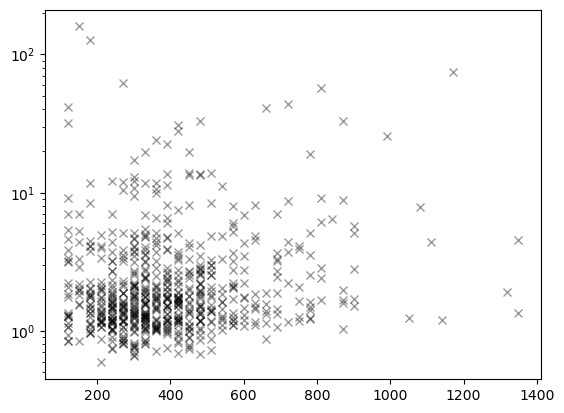

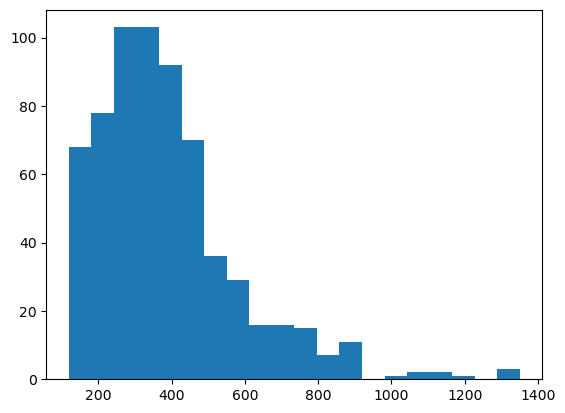

In [7]:
uncensored = flare_table.loc[(flare_table['peak_cps_NUV']!='--') &
                             (flare_table['right_censored']==0) &
                             (flare_table['left_censored']==0) &
                             (flare_table['qa_flag_nuv']==0)]
plt.plot(uncensored['duration'],uncensored['peak_cps_NUV'],'kx',alpha=0.4)
plt.semilogy()

plt.figure()
plt.hist(uncensored['duration'],bins=20);

In [8]:
flare_table.loc[(flare_table['qa_flag_nuv']==0) &
                (flare_table['qa_flag_fuv']==0)]

,eclipse,obj_id,ra,dec,simbad_n_match,simbad_otype,simbad_main_id,simbad_distance,simbad_distance_err_2,simbad_distance_err_1,...,peak_flux_FUV,peak_flux_err_FUV,peak_mag_FUV,peak_t0_FUV,quiescence_cps_FUV,quiescence_cps_err_FUV,quiescence_flux_FUV,quiescence_flux_err_FUV,quiescence_mag_FUV,quiescence_mag_err_FUV
1,1413,1953301413.0,311.565113,-4.930670,0,Low-Mass*,2MASS J20461427-0456025,817.8621084485156,65.98240829734561,-78.67724834533783,...,0.0,0.0,19.973362,743928496,0.324898,0.013665,0.0,0.0,16.830945,0.016733
2,1420,1468701420.0,315.935391,-7.379244,1,Low-Mass*,2MASS J21034437-0722434,484.8719937936385,67.54455660357485,-93.63083686476938,...,0.0,0.0,21.433751,743970140,0.288181,0.014946,0.0,0.0,17.607328,0.021929
3,1422,1479501422.0,343.352654,-39.793072,0,Galaxy,LEDA 2794348,--,--,--,...,--,--,--,--,--,--,--,--,--,--
4,1534,1091701534.0,259.445075,59.689607,1,Star,2MASS J17174656+5941240,129.1522446660123,2.0260592582583,-2.091685349043644,...,0.0,0.0,20.625874,744644285,0.169849,0.010239,0.0,0.0,18.349073,0.029758
4,1534,1091701534.0,259.445075,59.689607,1,Star,2MASS J17174656+5941240,129.1522446660123,2.0260592582583,-2.091685349043644,...,0.0,0.0,21.789698,744644165,0.169849,0.010239,0.0,0.0,18.349073,0.029758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049,46434,--,83.025278,-26.766145,0,WhiteDwarf_Candidate,Gaia DR3 2908651564812569216,1067.5776662752216,290.57689773814593,-637.7429747665781,...,--,--,--,--,--,--,--,--,--,--
2050,46438,--,91.025539,39.641683,1,X,1RXS J060407.5+393836,--,--,--,...,--,--,--,--,--,--,--,--,--,--
2051,46560,--,115.557791,40.030106,1,HighPM*,2MASS J07421381+4001505,46.142062181042995,0.03255209477141108,-0.032598089078341275,...,--,--,--,--,--,--,--,--,--,--
2057,46767,--,188.178706,-34.410847,0,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--


In [10]:
pos = list(zip(flare_table['ra'].values,flare_table['dec'].values))
labels = DBSCAN(eps=17.5/60/60,min_samples=1).fit(pos).labels_
print(f"There are {len(flare_table)} candidate flares identified across {len(np.unique(flare_table.eclipse))} visits,")
print(f" on {len(set(labels))} unique sources ")
print(f"of which {len(flare_table.loc[(flare_table['quiescence_cps_NUV']!='--') & (flare_table['quiescence_cps_FUV']!='--')])} were observed in both bands.")
print(f"NUV band encompassed energies were computed for {len(flare_table.loc[flare_table['energy_NUV']!='--'])} of the candidate flare events.")


There are 1128 candidate flares identified across 1010 visits,

on 883 unique sources

of which 540 were observed in both bands.

NUV band encompassed energies were computed for 963 of the candidate flare events.

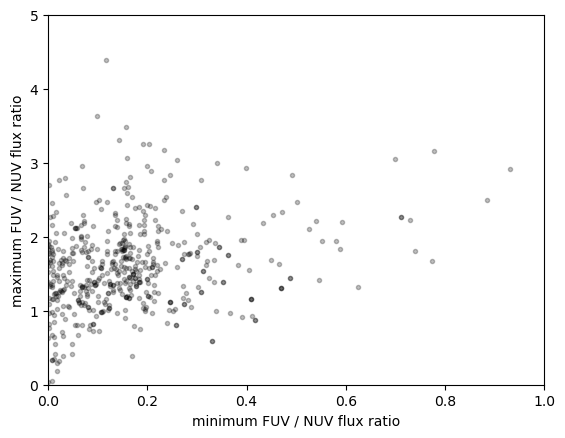

In [11]:
plt.plot(np.array(flare_table.loc[(flare_table['qa_flag_nuv']==0) &
                                  (flare_table['qa_flag_fuv']==0)]['ratio_min'].replace('--',np.nan),
                  dtype=float),
         np.array(flare_table.loc[(flare_table['qa_flag_nuv']==0) &
                                  (flare_table['qa_flag_fuv']==0)]['ratio_max'].replace('--',np.nan),
                  dtype=float),'k.',alpha=0.25)
#plt.plot(flare_table['ratio_min'],flare_table['ratio_max'],'kx');
plt.xlim([0,1])
plt.xlabel('minimum FUV / NUV flux ratio')
plt.ylim([0,5])
plt.ylabel('maximum FUV / NUV flux ratio')
plt.savefig('flare_ratios_dist.png',dpi=150)
plt.savefig('flare_ratios_dist.pdf',dpi=150)

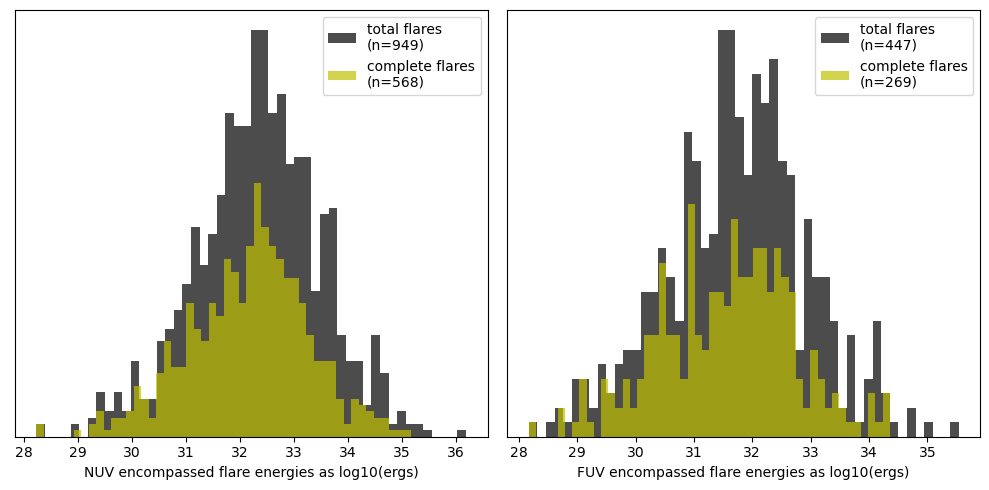

In [12]:
gs = gridspec.GridSpec(nrows=2, ncols=4)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(gs[:,:2])
flares_all = flare_table.loc[(flare_table['energy_NUV']!='--') &
                             (flare_table['qa_flag_nuv']==0)]
flares_complete = flare_table.loc[(flare_table['energy_NUV']!='--') &
                                  (flare_table['left_censored']==0) &
                                  (flare_table['right_censored']==0) &
                                  (flare_table['qa_flag_nuv']==0)]
ax.hist(flares_all['energy_NUV'],bins=50,label=f"total flares\n(n={len(flares_all)})",color='k',alpha=0.7)
ax.hist(flares_complete['energy_NUV'],bins=50,label=f"complete flares\n(n={len(flares_complete)})",color='y',alpha=0.7)
ax.set_yticks([])
ax.set_xlabel('NUV encompassed flare energies as log10(ergs)')
ax.legend()

ax = fig.add_subplot(gs[:,2:])
flares_all = flare_table.loc[(flare_table['energy_FUV']!='--') &
                             (flare_table['qa_flag_fuv']==0)]
flares_complete = flare_table.loc[(flare_table['energy_FUV']!='--') &
                                  (flare_table['left_censored']==0) &
                                  (flare_table['right_censored']==0) &
                                  (flare_table['qa_flag_fuv']==0)]
ax.hist(flares_all['energy_FUV'],bins=50,label=f"total flares\n(n={len(flares_all)})",color='k',alpha=0.7)
ax.hist(flares_complete['energy_FUV'],bins=50,label=f"complete flares\n(n={len(flares_complete)})",color='y',alpha=0.7)
ax.set_yticks([])
ax.set_xlabel('FUV encompassed flare energies as log10(ergs)')
ax.legend()
plt.tight_layout()
plt.savefig('flare_energy_dist.png',dpi=150)
plt.savefig('flare_energy_dist.pdf',dpi=150)

Flare energy detection limits are basically determined by stellar distance.

The range of stellar distances is 2.674910296032687 to 2823.8222938079643 parsecs.

The range of flare energies is 28.237212905710457 to 36.19154349405514.

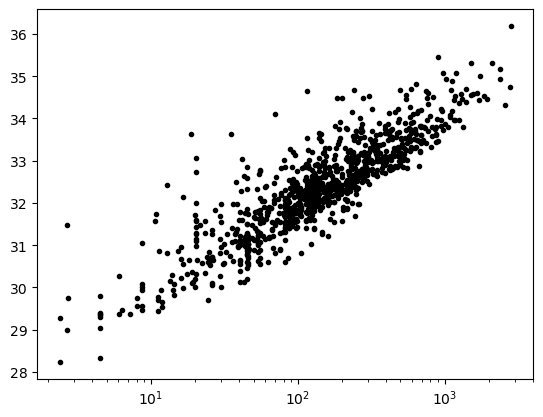

In [13]:
print('Flare energy detection limits are basically determined by stellar distance.')
d = np.array(flares_all['distance'].values,dtype=float)
d_err = (np.array(flares_all['distance'].values,dtype=float),
         np.array(flares_all['distance'].values,dtype=float))
print(f"The range of stellar distances is {min(d)} to {max(d)} parsecs.")
flares_all = flare_table.loc[(flare_table['energy_NUV']!='--') &
                             (flare_table['qa_flag_nuv']==0)]
e = flares_all['energy_NUV'].values
print(f"The range of flare energies is {min(e)} to {max(e)}.")
plt.figure()
plt.plot(np.array(flares_all['distance'].values,dtype=float),e,'k.')
plt.semilogx();

In [14]:
flares_all[flares_all['energy_NUV']>35].sort_values('energy_NUV')[['eclipse','ra','dec','energy_NUV','energy_err_1_NUV','energy_err_2_NUV','simbad_otype','simbad_main_id','gaia_match_offset','gaia_n_match','simbad_distance','gaia_distance','gaia_distance_err_1','gaia_distance_err_2','gaia_parallax_over_err']]

,eclipse,ra,dec,energy_NUV,energy_err_1_NUV,energy_err_2_NUV,simbad_otype,simbad_main_id,gaia_match_offset,gaia_n_match,simbad_distance,gaia_distance,gaia_distance_err_1,gaia_distance_err_2,gaia_parallax_over_err
838,21750,202.736280,65.717210,35.014552,34.190892,34.217838,HotSubdwarf_Candidate,FBS 1329+659,1.8937014999601967,2,1730.7026652821046,1730.6568823026425,-56.26523642918164,52.83012515677888,31.75890350341797
1547,4158,85.835165,-41.032337,35.065821,33.87839,33.886999,"CataclyV*, Star, X",Gaia DR3 4804695423438691200,1.826724122021196,4,980.7767752059631,980.7517370226549,-19.623099448373296,18.86806648526499,50.97945022583008
177,6975,335.830307,-8.879691,35.080101,34.467042,34.436684,--,--,2.085567846296441,1,--,1196.829353576235,-147.30097143004787,118.20465806170091,9.12506103515625
1246,35016,11.892994,40.780813,35.176234,34.591169,34.579295,--,--,2.782927257679524,2,--,2389.6264159894195,-293.71042423437484,235.75648152487793,9.135994911193848
1043,28516,311.199490,-0.069217,35.301518,34.932533,34.881463,--,--,2.0619796231118013,1,--,2085.056176591997,-485.1062880709792,331.05888355677735,5.29814338684082
1054,28668,9.065145,1.388873,35.304289,34.344371,34.357669,SB*,BD+00 85,1.9261490622334594,1,1501.7269860339388,1501.7256578753254,-54.09762327095791,50.46197528907646,28.75954818725586
1869,37332,151.679085,36.946968,35.442974,34.164939,34.164751,Star,TYC 2509-883-1,2.4420197408639535,2,900.1710324961742,900.1579580146947,-19.491149683606636,18.68210138011284,47.18290710449219
206,7500,10.949448,-44.858973,36.191543,35.353459,35.340554,delSctV*,GUVV J004347.7-445130.7,1.8919073671889701,1,2824.060999717594,2823.8222938079643,-192.9155156506722,169.7252253550705,15.637611389160156


(0.0, 3.0)

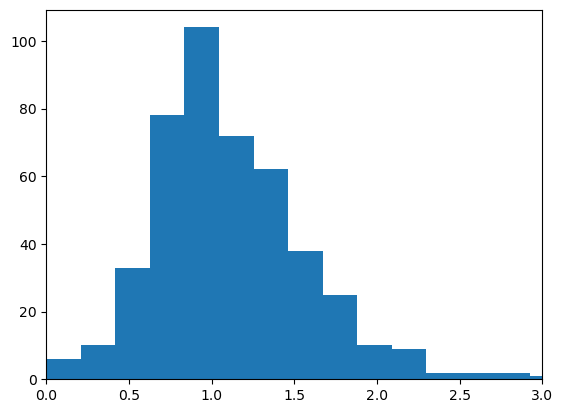

In [15]:
plt.hist(np.array(flares_all['ratio_at_nuv_max'].replace('--',np.nan).values,dtype='float'),bins=200)
plt.xlim([0,3])

In [16]:
flares_all

,eclipse,obj_id,ra,dec,simbad_n_match,simbad_otype,simbad_main_id,simbad_distance,simbad_distance_err_2,simbad_distance_err_1,...,peak_flux_FUV,peak_flux_err_FUV,peak_mag_FUV,peak_t0_FUV,quiescence_cps_FUV,quiescence_cps_err_FUV,quiescence_flux_FUV,quiescence_flux_err_FUV,quiescence_mag_FUV,quiescence_mag_err_FUV
1,1413,1953301413.0,311.565113,-4.930670,0,Low-Mass*,2MASS J20461427-0456025,817.8621084485156,65.98240829734561,-78.67724834533783,...,0.0,0.0,19.973362,743928496,0.324898,0.013665,0.0,0.0,16.830945,0.016733
2,1420,1468701420.0,315.935391,-7.379244,1,Low-Mass*,2MASS J21034437-0722434,484.8719937936385,67.54455660357485,-93.63083686476938,...,0.0,0.0,21.433751,743970140,0.288181,0.014946,0.0,0.0,17.607328,0.021929
3,1422,1479501422.0,343.352654,-39.793072,0,Galaxy,LEDA 2794348,--,--,--,...,--,--,--,--,--,--,--,--,--,--
4,1534,1091701534.0,259.445075,59.689607,1,Star,2MASS J17174656+5941240,129.1522446660123,2.0260592582583,-2.091685349043644,...,0.0,0.0,20.625874,744644285,0.169849,0.010239,0.0,0.0,18.349073,0.029758
7,1623,1417401623.0,259.204219,60.039535,1,QSO,[PCE2006] 6680,--,--,--,...,--,--,--,--,--,--,--,--,--,--
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2047,46423,--,72.780973,16.379870,3,"**, HighPM*",Gaia DR3 3405240498233928704,65.3483721720492,0.23869491943065668,-0.2404514910906812,...,--,--,--,--,--,--,--,--,--,--
2049,46434,--,83.025278,-26.766145,0,WhiteDwarf_Candidate,Gaia DR3 2908651564812569216,1067.5776662752216,290.57689773814593,-637.7429747665781,...,--,--,--,--,--,--,--,--,--,--
2050,46438,--,91.025539,39.641683,1,X,1RXS J060407.5+393836,--,--,--,...,--,--,--,--,--,--,--,--,--,--
2051,46560,--,115.557791,40.030106,1,HighPM*,2MASS J07421381+4001505,46.142062181042995,0.03255209477141108,-0.032598089078341275,...,--,--,--,--,--,--,--,--,--,--


## Eclipses

In [17]:
eix = pd.read_csv('eclipse_targets_by_index.csv',index_col=None).ix.values
etbl = tbl.loc[eix]
etbl.replace(np.nan, '--', inplace=True)
etbl.to_csv('gfcat_eclipse_table.csv',index=None)
etbl

,eclipse,obj_id,ra,dec,simbad_n_match,simbad_otype,simbad_main_id,simbad_distance,simbad_distance_err_2,simbad_distance_err_1,...,skybg_flux_NUV,skybg_flux_err_NUV,expt_eff_FUV,skybg_counts_FUV,skybg_counts_err_FUV,skybg_flux_FUV,skybg_flux_err_FUV,morphology,qa_flag_nuv,qa_flag_fuv
1807,32725,--,217.215396,49.902299,2,"X, blue",GALEX 2685880428793954899,--,--,--,...,2.627456780966711e-13,1.405877188515978e-14,--,--,--,--,--,E,0,0
1131,31289,1156931289.0,187.863493,0.692234,1,WhiteDwarf,SDSS J123127.15+004133.1,1155.4015020219526,529.5017815449825,-6346.475458899704,...,4.0019578005481564e-13,1.724802603085068e-14,--,--,--,--,--,E,0,0
317,9225,154809225.0,160.987286,58.125049,2,"CataclyV*, Star",V* IY UMa,182.04656751196956,2.2066250927519206,-2.2614480772375884,...,3.371158100559207e-13,2.2380632965774305e-14,--,--,--,--,--,E,0,0
944,25607,1401425607.0,169.316861,17.961371,2,"CataclyV*, Planet",NAME DP Leo b,305.0547573289406,26.433375109761755,-31.974664148064164,...,2.0821889037298864e-13,1.4001965964744092e-14,1003.1431240225187,87.59584900495845,6.686582180976134,1.2263418860694186e-13,4.0716252949867525e-14,E,0,0
380,9900,778109900.0,135.096777,43.803453,1,blue,US 2112,634.9609499015811,71.58066969463937,-92.41758035666953,...,3.4767351307056714e-13,2.2351398075346426e-14,1629.0649102408693,182.43861909432457,9.649855534120439,2.554140667320544e-13,9.006900130058083e-14,E,0,0
1213,33838,2634333838.0,11.441877,41.841258,5,"**, Cepheid, ClassicalCep, Cluster*, Star, Var...",Gaia DR2 375297888752001664,--,--,--,...,1.6451219075063822e-12,3.3228179359721047e-14,--,--,--,--,--,E,0,0
471,11840,1236511840.0,255.555757,32.498035,1,CataclyV*,V* V1239 Her,302.4437454633438,7.197214690096189,-7.556874626107856,...,2.6072418774998996e-13,1.5383879273335396e-14,--,--,--,--,--,E,0,0
110,5421,1457905421.0,261.001054,60.747283,1,WhiteDwarf_Candidate,ZTF J172400.04+604451.8,689.2273761113792,167.27946748704142,-325.0742808796192,...,3.1856146841874617e-13,1.4554810073075755e-14,1310.3837306432983,238.8148671746567,11.040610873213993,3.343408140445194e-13,4.1935926376670585e-14,E,0,0
1350,38760,1358838760.0,322.437197,0.606890,0,Low-Mass*,SDSS J212946.51+003628.3,23041.47465437788,20825.653720103677,25784.958837352133,...,3.4601770545116493e-13,1.4860450279640658e-14,--,--,--,--,--,E,0,0
534,13484,1834913484.0,19.602606,34.751098,0,GtowardsCl,DES J011826.25+344522.0,--,--,--,...,3.149086756480225e-13,1.4788032536011084e-14,1246.5332712652757,197.41475753804872,10.038116481361383,2.763806605532682e-13,4.0021108777862403e-14,E,0,0


In [18]:
print(etbl.replace('--',np.nan).astype(
    {'mag_min_NUV':float,'mag_max_NUV':float,'mag_min_err_NUV':float,'mag_max_err_NUV':float}).round(
    {'ra':2,'dec':2,'mag_min_NUV':2,'mag_max_NUV':2,'mag_min_err_NUV':2,'mag_max_err_NUV':2}).iloc[-20:][
    ['datetime_iso','ra','dec','simbad_otype','mag_min_NUV','mag_max_NUV','mag_min_err_NUV','mag_max_err_NUV']].to_latex(index=False))

\begin{tabular}{lrrlrrrr}
\toprule
       datetime\_iso &     ra &    dec &          simbad\_otype &  mag\_min\_NUV &  mag\_max\_NUV &  
mag\_min\_err\_NUV &  mag\_max\_err\_NUV \\
\midrule
2011-04-07T10:14:58 & 200.62 &   1.01 &            WhiteDwarf &        20.54 &        18.68 &             0.55 &   
0.10 \\
2008-04-21T04:30:54 & 193.90 &  27.06 & Galaxy, HighPM*, Star &        17.61 &        15.84 &             0.06 &   
0.06 \\
2009-01-20T02:26:15 & 127.89 &  32.46 &                  Star &        14.83 &        14.59 &             0.06 &   
0.02 \\
2008-08-19T03:35:59 & 320.05 &  -0.56 &                   NaN &        19.95 &        17.54 &             0.18 &   
0.06 \\
2004-07-16T15:32:39 & 338.88 &  14.48 &                    ** &        20.17 &        18.08 &             0.20 &   
0.08 \\
2009-07-26T09:44:45 & 320.64 &  -6.31 &            WhiteDwarf &        20.05 &        18.78 &             0.19 &   
0.11 \\
2009-06-18T13:00:23 & 207.74 &  26.56 &            Cepheid, X &        19.24 &        18.02 &             0.13 &   
0.08 \\
2005-01-17T01:03:44 & 160.99 &  58.13 &       CataclyV*, Star &        19.82 &        17.66 &             0.17 &   
0.07 \\
2006-01-13T03:56:00 & 160.99 &  58.13 &       CataclyV*, Star &        19.88 &        17.77 &             0.18 &   
0.07 \\
2004-07-24T14:07:05 & 338.88 &  14.48 &                    ** &        20.11 &        18.03 &             0.19 &   
0.08 \\
2011-02-01T06:43:59 & 154.58 &   8.30 &                   NaN &        20.09 &        18.87 &             0.19 &   
0.11 \\
2005-03-02T01:59:43 & 160.99 &  58.13 &       CataclyV*, Star &        20.15 &        17.27 &             0.20 &   
0.06 \\
2005-07-27T18:47:31 & 261.00 &  60.75 &  WhiteDwarf\_Candidate &        20.26 &        18.94 &             0.21 &  
0.12 \\
2010-07-02T10:37:48 & 292.67 &  40.87 &                  Star &        17.02 &        15.89 &             0.06 &   
0.03 \\
2006-07-11T03:28:55 & 254.28 &  -4.35 &             Eruptive* &        18.65 &        16.50 &             0.11 &   
0.09 \\
2011-10-07T13:13:23 & 346.26 &  17.41 &                   NaN &        19.71 &        18.23 &             0.16 &   
0.09 \\
2010-02-07T14:14:37 & 158.89 &   5.87 &             CataclyV* &        19.86 &        18.70 &             0.17 &   
0.11 \\
2007-02-22T05:17:04 & 137.05 &   6.07 &            WhiteDwarf &        19.98 &        17.01 &             0.18 &   
0.05 \\
2011-12-20T05:42:03 &  77.16 & -24.20 &                PulsV* &        17.64 &        16.67 &             0.07 &   
0.04 \\
2006-06-01T08:39:07 & 217.91 &  32.74 &              **, Star &        15.72 &        15.48 &             0.03 &   
0.02 \\
\bottomrule
\end{tabular}